## 1.数据处理

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import lightgbm as lgb
import xgboost as xgb

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, GridSearchCV
# from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

import matplotlib.pylab as plt
%matplotlib inline
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 12, 4

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_seq_items', None)

In [2]:
# 读取数据
# train_file = 'd:/oppo/input/oppo_round1_train_20180929.txt'
valid_file = 'd:/oppo/input/oppo_round1_vali_20180929.txt'
test_A_file = 'd:/oppo/input/oppo_round1_test_A_20180929.txt'
# train_df = pd.read_csv(train_file, sep='\t', header=None,names=['prefix', 'query_prediction', 'title', 'tag', 'label'])
valid_df = pd.read_csv(valid_file, sep='\t', header=None,names=['prefix', 'query_prediction', 'title', 'tag', 'label'])
test_data = pd.read_csv(test_A_file, sep='\t', header=None, names=['prefix', 'query_prediction', 'title', 'tag'])
test_data['label'] = -1

In [3]:
# 训练集数据预处理
def train_preprocess():
    print('preprocessing train data start')
    # prefix有4个null，被误认为是空值，使用‘realnull’填充
    file_path = 'd:/oppo/input/train_preprocessed.pkl'
    if os.path.exists(file_path):
        train_preprocessed = pickle.load(open(file_path,'rb'))
    else:
        train_file = 'd:/oppo/input/oppo_round1_train_20180929.txt'
        train_df = pd.read_csv(train_file, sep='\t', header=None,
                       names=['prefix', 'query_prediction', 'title', 'tag', 'label'])
        print('data is null?\n',train_df.isnull().sum())
        # fill the np.nan of column 'prefix' with 'null'
        train_df['prefix'] = train_df['prefix'].fillna('null')
        print('data is null?\n',train_df.isnull().sum())
        
        # modify the wrong line 1815101
        print(train_df[train_df.prefix=='花开花又'])
        train_df.loc[train_df.prefix=='花开花又','query_prediction'] = '{"花开花又落": "0.635", "花开花又落是什么歌": "0.365"}'
        train_df.loc[train_df.prefix=='花开花又','title'] = '大雁听过我的歌%2C山丹丹花开花又落....一年又一年?谁听过这首歌%2C知道歌名吗?'
        train_df.loc[train_df.prefix=='花开花又','tag'] = '知道'
        train_df.loc[train_df.prefix=='花开花又','label'] = 0
        print(train_df[train_df.prefix=='花开花又'])
        # add the missed line to end
        train_df.loc[1999999,'prefix'] = '花开花又'
        train_df.loc[1999999,'query_prediction'] = '{"花开花又落": "0.635", "花开花又落是什么歌": "0.365"}'
        train_df.loc[1999999,'title'] = '等你花开花又落'
        train_df.loc[1999999,'tag'] = '音乐'
        train_df.loc[1999999,'label'] = 0
        print(train_df[train_df.prefix=='花开花又'])
        
        # the label has 0,1,'0','1',transform '0','1' to 0,1 respectively
        print(train_df.label.value_counts())
        train_df.loc[train_df.label=='0','label']=0
        train_df.loc[train_df.label=='1','label']=1
        print(train_df.label.value_counts())
        train_df['label'] = train_df.label.astype('int')
        print(train_df.info())
        train_preprocessed = train_df
        del train_df
        pickle.dump(train_preprocessed,open(file_path,'wb'))
        train_df.to_csv('d:/oppo/input/train_preprocessed.csv',sep='\t',index=None,header=None)
    print('preprocessing train data end')
    return train_preprocessed
train_df = train_preprocess()

preprocessing train data start
preprocessing train data end


In [4]:
# 合并训练集和测试集
# train_data = pd.concat([train_df,valid_df])
# del train_df,valid_df
train_df['label'] = train_df['label'].apply(lambda x: int(x))
valid_df['label'] = valid_df['label'].apply(lambda x: int(x))
test_data['label'] = test_data['label'].apply(lambda x: int(x))

In [5]:
# train_df的平均点击率
train_df['label'].mean()

0.3720975

## 2.特征工程

### 2.1.prefix独立特征

### 2.1.1.prefix特征

In [7]:
train_df['prefix'].nunique()

157083

In [8]:
train_df['label'].sum()

744195

In [9]:
# prefix的平均点击次数
a = train_df['label'].sum()/train_df['prefix'].nunique()
a

4.73759095510017

In [10]:
loga = np.log1p(train_df['label'].sum())/np.log(train_df['prefix'].nunique())
loga

1.1300118069000622

In [11]:
# prefix的平均搜索次数
b =train_df['label'].count()/train_df['prefix'].nunique()
b

12.732122508482776

In [12]:
logb = np.log1p(train_df['label'].count())/np.log1p(train_df['prefix'].nunique())
logb

1.2126386072259883

In [13]:
train_df[['prefix','label']].groupby(['prefix'])['label'].describe()

         count      mean       std  min   25%  50%   75%  max
prefix                                                       
#         41.0  0.317073  0.471117  0.0  0.00  0.0  1.00  1.0
%         33.0  0.393939  0.496198  0.0  0.00  0.0  1.00  1.0
&         14.0  0.428571  0.513553  0.0  0.00  0.0  1.00  1.0
(女人        1.0  1.000000       NaN  1.0  1.00  1.0  1.00  1.0
*p++       1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
-          1.0  1.000000       NaN  1.0  1.00  1.0  1.00  1.0
.        815.0  0.353374  0.478311  0.0  0.00  0.0  1.00  1.0
.          9.0  0.333333  0.500000  0.0  0.00  0.0  1.00  1.0
...b       2.0  0.500000  0.707107  0.0  0.25  0.5  0.75  1.0
.b         4.0  0.000000  0.000000  0.0  0.00  0.0  0.00  0.0
.cn        4.0  0.750000  0.500000  0.0  0.75  1.0  1.00  1.0
.com       3.0  0.333333  0.577350  0.0  0.00  0.0  0.50  1.0
.comp      1.0  0.000000       NaN  0.0  0.00  0.0  0.00  0.0
.e         2.0  0.500000  0.707107  0.0  0.25  0.5  0.75  1.0
.i      

In [14]:
# prefix的点击次数和搜索次数
feature_prefix = train_df[['prefix','label']].groupby('prefix', as_index = False)['label'].agg({'prefix_click':'sum', 'prefix_count':'count'})

In [14]:
feature_prefix['prefix_click'].describe()

count    157083.000000
mean          4.737591
std          40.141294
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        7090.000000
Name: prefix_click, dtype: float64

In [15]:
feature_prefix['prefix_count'].describe()

count    157083.000000
mean         12.732123
std         109.844814
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max       20066.000000
Name: prefix_count, dtype: float64

In [15]:
# prefix点击次数和搜索次数的平滑处理
feature_prefix['prefix_click_smooth'] = feature_prefix['prefix_click']+a
feature_prefix['prefix_count_smooth'] = feature_prefix['prefix_count']+b

In [17]:
# prefix点击数和搜索数的log变换
feature_prefix['prefix_click_log'] = np.log1p(feature_prefix['prefix_click'])
feature_prefix['prefix_count_log'] = np.log1p(feature_prefix['prefix_count'])

In [17]:
temp['prefix_click_log'].describe()

count    157083.000000
mean          0.919055
std           0.880951
min           0.000000
25%           0.693147
50%           0.693147
75%           1.098612
max           8.866582
Name: prefix_click_log, dtype: float64

In [18]:
temp['prefix_count_log'].describe()

count    157083.000000
mean          1.549993
std           0.998237
min           0.693147
25%           0.693147
50%           1.098612
75%           1.945910
max           9.906832
Name: prefix_count_log, dtype: float64

In [18]:
# 对prefix点击数和搜索数的log变换再做一次log变换
feature_prefix['prefix_click_log2'] = np.log1p(feature_prefix['prefix_click_log'])
feature_prefix['prefix_count_log2'] = np.log1p(feature_prefix['prefix_count_log'])

In [20]:
temp['prefix_click_log2'].describe()

count    157083.000000
mean          0.564525
std           0.407813
min           0.000000
25%           0.526589
50%           0.526589
75%           0.741276
max           2.289153
Name: prefix_click_log2, dtype: float64

In [21]:
temp['prefix_count_log2'].describe()

count    157083.000000
mean          0.875779
std           0.330472
min           0.526589
25%           0.526589
50%           0.741276
75%           1.080418
max           2.389389
Name: prefix_count_log2, dtype: float64

In [19]:
# prefix的点击数差值与搜索数差值
feature_prefix['prefix_click_diff'] = feature_prefix['prefix_click'] - feature_prefix['prefix_click'].mean()
feature_prefix['prefix_count_diff'] = feature_prefix['prefix_count'] - feature_prefix['prefix_count'].mean()

In [23]:
temp['prefix_click_diff'].describe()

count    1.570830e+05
mean    -1.942131e-13
std      4.014129e+01
min     -4.737591e+00
25%     -3.737591e+00
50%     -3.737591e+00
75%     -2.737591e+00
max      7.085262e+03
Name: prefix_click_diff, dtype: float64

In [24]:
temp['prefix_count_diff'].describe()

count    1.570830e+05
mean     2.837283e-13
std      1.098448e+02
min     -1.173212e+01
25%     -1.173212e+01
50%     -1.073212e+01
75%     -6.732123e+00
max      2.005327e+04
Name: prefix_count_diff, dtype: float64

In [20]:
# prefix的点击数占比与搜索数占比
feature_prefix['prefix_click_ratio'] = feature_prefix['prefix_click']/feature_prefix['prefix_click'].sum()
feature_prefix['prefix_count_ratio'] = feature_prefix['prefix_count']/feature_prefix['prefix_count'].sum()

In [33]:
temp['prefix_click_ratio'].describe()

count    157083.000000
mean          0.000006
std           0.000054
min           0.000000
25%           0.000001
50%           0.000001
75%           0.000003
max           0.009527
Name: prefix_click_ratio, dtype: float64

In [34]:
temp['prefix_count_ratio'].describe()

count    1.570830e+05
mean     6.366061e-06
std      5.492241e-05
min      5.000000e-07
25%      5.000000e-07
50%      1.000000e-06
75%      3.000000e-06
max      1.003300e-02
Name: prefix_count_ratio, dtype: float64

In [21]:
# prefix的点击数log占比与搜索数log占比
feature_prefix['prefix_click_ratio_log'] = np.log1p(feature_prefix['prefix_click'])-np.log1p(feature_prefix['prefix_click'].sum())
feature_prefix['prefix_count_ratio_log'] = np.log1p(feature_prefix['prefix_count'])-np.log1p(feature_prefix['prefix_count'].sum())

In [39]:
temp['prefix_click_ratio_log'].describe()

count    157083.000000
mean        -12.601005
std           0.880951
min         -13.520060
25%         -12.826913
50%         -12.826913
75%         -12.421447
max          -4.653478
Name: prefix_click_ratio_log, dtype: float64

In [40]:
temp['prefix_count_ratio_log'].describe()

count    157083.000000
mean        -12.958666
std           0.998237
min         -13.815511
25%         -13.815511
50%         -13.410046
75%         -12.562748
max          -4.601826
Name: prefix_count_ratio_log, dtype: float64

In [50]:
temp.columns

Index(['prefix', 'prefix_click', 'prefix_count', 'prefix_click_log',
       'prefix_count_log', 'prefix_click_log2', 'prefix_count_log2',
       'prefix_click_diff', 'prefix_count_diff', 'prefix_click_diff_log',
       'prefix_count_diff_log', 'prefix_click_diff_log2',
       'prefix_count_diff_log2', 'prefix_click_ratio', 'prefix_count_ratio',
       'prefix_click_ratio_log', 'prefix_count_ratio_log'],
      dtype='object')

In [22]:
# prefix的绝对搜索转化率
feature_prefix['prefix_ctr_abs'] = feature_prefix['prefix_click']/(feature_prefix['prefix_count'])
feature_prefix['prefix_ctr_abs'].describe()

count    157083.000000
mean          0.400028
std           0.311563
min           0.000000
25%           0.166667
50%           0.388889
75%           0.500000
max           1.000000
Name: prefix_ctr_abs, dtype: float64

In [23]:
# prefix的贝叶斯平滑搜索转换率
feature_prefix['prefix_ctr_smooth'] = (feature_prefix['prefix_click']+a)/(feature_prefix['prefix_count']+b)
feature_prefix['prefix_ctr_smooth'].describe()

count    157083.000000
mean          0.375082
std           0.043074
min           0.037697
25%           0.345001
50%           0.379965
75%           0.402674
max           0.881683
Name: prefix_ctr_smooth, dtype: float64

In [24]:
# prefix的绝对转化率差值
feature_prefix['prefix_ctr_diff'] = feature_prefix['prefix_ctr_abs'] - feature_prefix['prefix_ctr_abs'].mean()
feature_prefix['prefix_ctr_diff'].describe()

count    1.570830e+05
mean    -1.015851e-13
std      3.115627e-01
min     -4.000277e-01
25%     -2.333610e-01
50%     -1.113878e-02
75%      9.997233e-02
max      5.999723e-01
Name: prefix_ctr_diff, dtype: float64

In [25]:
# prefix的相对转化率
feature_prefix['prefix_ctr_rela'] = feature_prefix['prefix_ctr_diff']/(feature_prefix['prefix_ctr_abs'].mean())
feature_prefix['prefix_ctr_rela'].describe()

count    1.570830e+05
mean    -2.552491e-13
std      7.788528e-01
min     -1.000000e+00
25%     -5.833622e-01
50%     -2.784504e-02
75%      2.499135e-01
max      1.499827e+00
Name: prefix_ctr_rela, dtype: float64

In [26]:
# prefix的绝对转换率log
feature_prefix['prefix_ctr_log_abs'] = feature_prefix['prefix_click_log']/(feature_prefix['prefix_count_log'])
feature_prefix['prefix_ctr_log_abs'].describe()

count    157083.000000
mean          0.532285
std           0.335173
min           0.000000
25%           0.366532
50%           0.630930
75%           0.748873
max           1.000000
Name: prefix_ctr_log_abs, dtype: float64

In [27]:
# prefix的log贝叶斯平滑转换率
feature_prefix['prefix_ctr_log_smooth'] = (feature_prefix['prefix_click_log']+np.log1p(a))/(feature_prefix['prefix_count_log']+np.log1p(b))
feature_prefix['prefix_ctr_log_smooth'].describe()

count    157083.000000
mean          0.632407
std           0.088276
min           0.260205
25%           0.534467
50%           0.656255
75%           0.710265
max           0.872975
Name: prefix_ctr_log_smooth, dtype: float64

In [28]:
# prefix的log绝对转化率差值
feature_prefix['prefix_ctr_log_diff'] = feature_prefix['prefix_ctr_log_abs'] - feature_prefix['prefix_ctr_log_abs'].mean()
feature_prefix['prefix_ctr_log_diff'].describe()

count    1.570830e+05
mean    -1.483742e-13
std      3.351726e-01
min     -5.322854e-01
25%     -1.657532e-01
50%      9.864436e-02
75%      2.165878e-01
max      4.677146e-01
Name: prefix_ctr_log_diff, dtype: float64

In [29]:
# prefix的log相对转化率
feature_prefix['prefix_ctr_log_rela'] = feature_prefix['prefix_ctr_log_diff']/(feature_prefix['prefix_ctr_log_abs'].mean())
feature_prefix['prefix_ctr_log_rela'].describe()

count    1.570830e+05
mean    -2.804937e-13
std      6.296859e-01
min     -1.000000e+00
25%     -3.113992e-01
50%      1.853223e-01
75%      4.069017e-01
max      8.786914e-01
Name: prefix_ctr_log_rela, dtype: float64

In [30]:
train_df = pd.merge(train_df, feature_prefix, on='prefix', how='left')
valid_df = pd.merge(valid_df, feature_prefix, on='prefix', how='left')
test_data = pd.merge(test_data, feature_prefix, on='prefix', how='left')
feature_prefix.to_csv('d:/oppo/input/prefix_feature.txt',sep='\t',index=False)
del feature_prefix

In [32]:
# prefix的点击次数和搜索次数
temp = train_df[['prefix','label']].groupby('prefix', as_index = False)['label'].agg({'prefix_click':'sum', 'prefix_count':'count'})
# prefix点击数和搜索数的log变换
temp['prefix_click_log'] = np.log1p(temp['prefix_click'])
temp['prefix_count_log'] = np.log1p(temp['prefix_count'])
# 对prefix点击数和搜索数的log变换再做一次log变换
temp['prefix_click_log2'] = np.log1p(temp['prefix_click_log'])
temp['prefix_count_log2'] = np.log1p(temp['prefix_count_log'])

# prefix的点击数差值与搜索数差值
temp['prefix_click_diff'] = temp['prefix_click'] - temp['prefix_click'].mean()
temp['prefix_count_diff'] = temp['prefix_count'] - temp['prefix_count'].mean()

# prefix的点击数占比与搜索数占比
temp['prefix_click_ratio'] = temp['prefix_click']/temp['prefix_click'].sum()
temp['prefix_count_ratio'] = temp['prefix_count']/temp['prefix_count'].sum()
# prefix的点击数log占比与搜索数log占比
temp['prefix_click_ratio_log'] = np.log1p(temp['prefix_click'])-np.log1p(temp['prefix_click'].sum())
temp['prefix_count_ratio_log'] = np.log1p(temp['prefix_count'])-np.log1p(temp['prefix_count'].sum())

# prefix的绝对转化率
temp['prefix_ctr_abs'] = temp['prefix_click']/(temp['prefix_count'])
# prefix的贝叶斯平滑转换率
temp['prefix_ctr_smooth'] = (temp['prefix_click']+a)/(temp['prefix_count']+b)
# prefix的绝对转化率差值
temp['prefix_ctr_diff'] = temp['prefix_ctr_abs'] - temp['prefix_ctr_abs'].mean()
# prefix的相对转化率
temp['prefix_ctr_rela'] = temp['prefix_ctr_diff']/(temp['prefix_ctr_abs'].mean())

# prefix的log绝对转换率
temp['prefix_ctr_log_abs'] = temp['prefix_click_log']-(temp['prefix_count_log'])
# prefix的log贝叶斯平滑转换率
temp['prefix_ctr_log_smooth'] = (temp['prefix_click_log']+np.log1p(a))/(temp['prefix_count_log']+np.log1p(b))
# prefix的log绝对转化率差值
temp['prefix_ctr_log_diff'] = temp['prefix_ctr_log_abs'] - temp['prefix_ctr_log_abs'].mean()
# prefix的log相对转化率
temp['prefix_ctr_log_rela'] = temp['prefix_ctr_log_diff']/(temp['prefix_ctr_log_abs'].mean())


train_df = pd.merge(train_df, temp, on='prefix', how='left')
valid_df = pd.merge(valid_df, temp, on='prefix', how='left')
test_data = pd.merge(test_data, temp, on='prefix', how='left')
del temp
# 对于valid和test数据集中新出现的数值型特征，所有的缺失值用均值代替
for col in valid_df.columns[train_df.dtypes == 'float64']:
    valid_df.fillna(valid_df[col].mean())
for col in test_data.columns[test_data.dtypes == 'float64']:
    test_data.fillna(test_data[col].mean())

### 2.1.2.prefix长度特征

In [31]:
# prefix长度特征
train_df['prefix_len'] = train_df['prefix'].apply(len)
valid_df['prefix_len'] = valid_df['prefix'].apply(len)
test_data['prefix_len'] = test_data['prefix'].apply(len)

train_df[['prefix_len','label']].groupby(['prefix_len'])['label'].describe()

train_df['prefix_len'] = train_df['prefix_len'].map(lambda x: 8 if x>8 else x)
valid_df['prefix_len'] = valid_df['prefix_len'].map(lambda x: 8 if x>8 else x)
test_data['prefix_len'] = test_data['prefix_len'].map(lambda x: 8 if x>8 else x)
train_df[['prefix_len','label']].groupby(['prefix_len'])['label'].describe()

# 平均每个prefix_len的点击次数
a = train_df['label'].sum()/train_df['prefix_len'].nunique()
a

# 平均每个prefix_len的搜索次数
b = train_df['label'].count()/train_df['prefix_len'].nunique()
b

# prefix的点击次数和搜索次数
temp = train_df[['prefix_len','label']].groupby('prefix_len', as_index = False)['label'].agg({'prefixlen_click':'sum', 'prefixlen_count':'count'})

temp['prefixlen_click_log'] = np.log1p(temp['prefixlen_click'])
temp['prefixlen_count_log'] = np.log1p(temp['prefixlen_count'])

# prefixlen的点击数差值与搜索数差值
temp['prefixlen_click_diff'] = temp['prefixlen_click'] - temp['prefixlen_click'].mean()
temp['prefixlen_count_diff'] = temp['prefixlen_count'] - temp['prefixlen_count'].mean()

# prefix的点击数占比与搜索数占比
temp['prefixlen_click_ratio'] = temp['prefixlen_click']/temp['prefixlen_click'].sum()
temp['prefixlen_count_ratio'] = temp['prefixlen_count']/temp['prefixlen_count'].sum()

# prefix的绝对转化率
temp['prefixlen_ctr_abs'] = temp['prefixlen_click']/(temp['prefixlen_count'])
# prefix的贝叶斯平滑转换率
temp['prefixlen_ctr_smooth'] = (temp['prefixlen_click']+a)/(temp['prefixlen_count']+b)
# prefix的绝对转化率差值
temp['prefixlen_ctr_diff'] = temp['prefixlen_ctr_abs'] - temp['prefixlen_ctr_abs'].mean()
# prefix的相对转化率
temp['prefixlen_ctr_rela'] = temp['prefixlen_ctr_diff']/(temp['prefixlen_ctr_abs'].mean())

train_df = pd.merge(train_df, temp, on='prefix_len', how='left')
valid_df = pd.merge(valid_df, temp, on='prefix_len', how='left')
test_data = pd.merge(test_data, temp, on='prefix_len', how='left')
temp.to_csv('d:/oppo/input/prefixlen_feature.txt',sep='\t',index=False)
del temp

In [71]:
# prefix长度特征
train_df['prefix_len'] = train_df['prefix'].apply(len)
valid_df['prefix_len'] = valid_df['prefix'].apply(len)
test_data['prefix_len'] = test_data['prefix'].apply(len)

In [18]:
train_df[['prefix_len','label']].groupby(['prefix_len'])['label'].describe()

               count      mean       std  min   25%  50%  75%  max
prefix_len                                                        
1           216497.0  0.381285  0.485703  0.0  0.00  0.0  1.0  1.0
2           857335.0  0.367039  0.481997  0.0  0.00  0.0  1.0  1.0
3           452578.0  0.369932  0.482786  0.0  0.00  0.0  1.0  1.0
4           330275.0  0.375009  0.484126  0.0  0.00  0.0  1.0  1.0
5            85739.0  0.384434  0.486464  0.0  0.00  0.0  1.0  1.0
6            34472.0  0.388315  0.487374  0.0  0.00  0.0  1.0  1.0
7            14066.0  0.397057  0.489305  0.0  0.00  0.0  1.0  1.0
8             5300.0  0.414906  0.492752  0.0  0.00  0.0  1.0  1.0
9             2260.0  0.406195  0.491230  0.0  0.00  0.0  1.0  1.0
10            1138.0  0.427065  0.494869  0.0  0.00  0.0  1.0  1.0
11             135.0  0.451852  0.499530  0.0  0.00  0.0  1.0  1.0
12             113.0  0.495575  0.502208  0.0  0.00  0.0  1.0  1.0
13              55.0  0.418182  0.497807  0.0  0.00  0.0  1.0 

In [73]:
train_df['prefix_len'] = train_df['prefix_len'].map(lambda x: 8 if x>8 else x)
valid_df['prefix_len'] = valid_df['prefix_len'].map(lambda x: 8 if x>8 else x)
test_data['prefix_len'] = test_data['prefix_len'].map(lambda x: 8 if x>8 else x)
train_df[['prefix_len','label']].groupby(['prefix_len'])['label'].describe()

               count      mean       std  min  25%  50%  75%  max
prefix_len                                                       
1           216497.0  0.381285  0.485703  0.0  0.0  0.0  1.0  1.0
2           857335.0  0.367039  0.481997  0.0  0.0  0.0  1.0  1.0
3           452578.0  0.369932  0.482786  0.0  0.0  0.0  1.0  1.0
4           330275.0  0.375009  0.484126  0.0  0.0  0.0  1.0  1.0
5            85739.0  0.384434  0.486464  0.0  0.0  0.0  1.0  1.0
6            34472.0  0.388315  0.487374  0.0  0.0  0.0  1.0  1.0
7            14066.0  0.397057  0.489305  0.0  0.0  0.0  1.0  1.0
8             9038.0  0.416243  0.492962  0.0  0.0  0.0  1.0  1.0

In [75]:
# 平均每个prefix_len的点击次数
a = train_df['label'].sum()/train_df['prefix_len'].nunique()
a

93024.375

In [76]:
# 平均每个prefix_len的搜索次数
b = train_df['label'].count()/train_df['prefix_len'].nunique()
b

250000.0

In [77]:
# prefix的点击次数和搜索次数
temp = train_df[['prefix_len','label']].groupby('prefix_len', as_index = False)['label'].agg({'prefixlen_click':'sum', 'prefixlen_count':'count'})

In [80]:
temp['prefixlen_click'].describe()

count         8.000000
mean      93024.375000
std      107761.519193
min        3762.000000
25%       11435.750000
50%       57754.000000
75%      134747.750000
max      314675.000000
Name: prefixlen_click, dtype: float64

In [81]:
temp['prefixlen_count'].describe()

count         8.000000
mean     250000.000000
std      293895.440019
min        9038.000000
25%       29370.500000
50%      151118.000000
75%      360850.750000
max      857335.000000
Name: prefixlen_count, dtype: float64

In [82]:
temp['prefixlen_click_log'] = np.log1p(temp['prefixlen_click'])
temp['prefixlen_click_log'].describe()

count     8.000000
mean     10.562718
std       1.638610
min       8.232972
25%       9.283534
50%      10.862123
75%      11.802233
max      12.659299
Name: prefixlen_click_log, dtype: float64

In [83]:
temp['prefixlen_count_log'] = np.log1p(temp['prefixlen_count'])
temp['prefixlen_count_log'].describe()

count     8.000000
mean     11.518153
std       1.677676
min       9.109304
25%      10.223845
50%      11.822206
75%      12.786442
max      13.661585
Name: prefixlen_count_log, dtype: float64

In [84]:
# prefixlen的点击数差值与搜索数差值
temp['prefixlen_click_diff'] = temp['prefixlen_click'] - temp['prefixlen_click'].mean()
temp['prefixlen_count_diff'] = temp['prefixlen_count'] - temp['prefixlen_count'].mean()

In [85]:
temp['prefixlen_click_diff'].describe()

count         8.000000
mean          0.000000
std      107761.519193
min      -89262.375000
25%      -81588.625000
50%      -35270.375000
75%       41723.375000
max      221650.625000
Name: prefixlen_click_diff, dtype: float64

In [86]:
temp['prefixlen_count_diff'].describe()

count         8.000000
mean          0.000000
std      293895.440019
min     -240962.000000
25%     -220629.500000
50%      -98882.000000
75%      110850.750000
max      607335.000000
Name: prefixlen_count_diff, dtype: float64

In [87]:
# prefix的点击数占比与搜索数占比
temp['prefixlen_click_ratio'] = temp['prefixlen_click']/temp['prefixlen_click'].sum()
temp['prefixlen_count_ratio'] = temp['prefixlen_count']/temp['prefixlen_count'].sum()

In [88]:
temp['prefixlen_click_ratio'].describe()

count    8.000000
mean     0.125000
std      0.144803
min      0.005055
25%      0.015367
50%      0.077606
75%      0.181065
max      0.422839
Name: prefixlen_click_ratio, dtype: float64

In [89]:
temp['prefixlen_count_ratio'].describe()

count    8.000000
mean     0.125000
std      0.146948
min      0.004519
25%      0.014685
50%      0.075559
75%      0.180425
max      0.428667
Name: prefixlen_count_ratio, dtype: float64

In [90]:
# prefix的绝对转化率
temp['prefixlen_ctr_abs'] = temp['prefixlen_click']/(temp['prefixlen_count'])
temp['prefixlen_ctr_abs'].describe()

count    8.000000
mean     0.384914
std      0.016018
min      0.367039
25%      0.373739
50%      0.382859
75%      0.390501
max      0.416243
Name: prefixlen_ctr_abs, dtype: float64

In [91]:
# prefix的贝叶斯平滑转换率
temp['prefixlen_ctr_smooth'] = (temp['prefixlen_click']+a)/(temp['prefixlen_count']+b)
temp['prefixlen_ctr_smooth'].describe()

count    8.000000
mean     0.373172
std      0.002589
min      0.368181
25%      0.372746
50%      0.373696
75%      0.374359
max      0.376361
Name: prefixlen_ctr_smooth, dtype: float64

In [92]:
# prefix的绝对转化率差值
temp['prefixlen_ctr_diff'] = temp['prefixlen_ctr_abs'] - temp['prefixlen_ctr_abs'].mean()
temp['prefixlen_ctr_diff'].describe()

count    8.000000e+00
mean     1.387779e-17
std      1.601787e-02
min     -1.787549e-02
25%     -1.117457e-02
50%     -2.054605e-03
75%      5.586502e-03
max      3.132848e-02
Name: prefixlen_ctr_diff, dtype: float64

In [93]:
# prefix的相对转化率
temp['prefixlen_ctr_rela'] = temp['prefixlen_ctr_diff']/(temp['prefixlen_ctr_abs'].mean())
temp['prefixlen_ctr_rela'].describe()

count    8.000000e+00
mean     3.469447e-17
std      4.161414e-02
min     -4.644022e-02
25%     -2.903133e-02
50%     -5.337828e-03
75%      1.451363e-02
max      8.139086e-02
Name: prefixlen_ctr_rela, dtype: float64

In [95]:
train_df = pd.merge(train_df, temp, on='prefix_len', how='left')
valid_df = pd.merge(valid_df, temp, on='prefix_len', how='left')
test_data = pd.merge(test_data, temp, on='prefix_len', how='left')
del temp

In [98]:
# prefix长度没有缺失值
train_df.isnull().sum()

prefix                    0
query_prediction          0
title                     0
tag                       0
label                     0
prefix_click              0
prefix_count              0
prefix_click_log          0
prefix_count_log          0
prefix_click_log2         0
prefix_count_log2         0
prefix_click_diff         0
prefix_count_diff         0
prefix_click_ratio        0
prefix_count_ratio        0
prefix_click_ratio_log    0
prefix_count_ratio_log    0
prefix_ctr_abs            0
prefix_ctr_smooth         0
prefix_ctr_diff           0
prefix_ctr_rela           0
prefix_ctr_log_abs        0
prefix_ctr_log_smooth     0
prefix_ctr_log_diff       0
prefix_ctr_log_rela       0
prefix_len                0
prefixlen_click           0
prefixlen_count           0
prefixlen_click_log       0
prefixlen_count_log       0
prefixlen_click_diff      0
prefixlen_count_diff      0
prefixlen_click_ratio     0
prefixlen_count_ratio     0
prefixlen_ctr_abs         0
prefixlen_ctr_smooth

### 2.1.3.query_prediction特征

In [32]:
# query_prediction个数
def split_prediction(text):
    if pd.isna(text): return []
    return [s.strip() for s in text.replace("{", "").replace("}", "").split(", ")]
train_df['pred_list'] = train_df['query_prediction'].apply(split_prediction)
train_df['pred_len'] = train_df['pred_list'].apply(len)

valid_df['pred_list'] = valid_df['query_prediction'].apply(split_prediction)
valid_df['pred_len'] = valid_df['pred_list'].apply(len)

test_data['pred_list'] = test_data['query_prediction'].apply(split_prediction)
test_data['pred_len'] = test_data['pred_list'].apply(len)


In [100]:
train_df['pred_len'].describe()

count    2.000000e+06
mean     9.412712e+00
std      1.484274e+00
min      1.000000e+00
25%      9.000000e+00
50%      1.000000e+01
75%      1.000000e+01
max      1.000000e+01
Name: pred_len, dtype: float64

In [33]:
train_df[['pred_len','label']].groupby(['pred_len'])['label'].describe()

              count      mean       std  min  25%  50%  75%  max
pred_len                                                        
1           20639.0  0.408547  0.491577  0.0  0.0  0.0  1.0  1.0
2           14593.0  0.416433  0.492984  0.0  0.0  0.0  1.0  1.0
3           11998.0  0.403067  0.490534  0.0  0.0  0.0  1.0  1.0
4           11814.0  0.404605  0.490836  0.0  0.0  0.0  1.0  1.0
5           13207.0  0.407663  0.491418  0.0  0.0  0.0  1.0  1.0
6           12399.0  0.388660  0.487466  0.0  0.0  0.0  1.0  1.0
7           14982.0  0.408824  0.491633  0.0  0.0  0.0  1.0  1.0
8          128500.0  0.375058  0.484140  0.0  0.0  0.0  1.0  1.0
9          299634.0  0.375024  0.484130  0.0  0.0  0.0  1.0  1.0
10        1472234.0  0.368947  0.482520  0.0  0.0  0.0  1.0  1.0

In [34]:
# 平均每个pred_len的点击次数
a = train_df['label'].sum()/train_df['pred_len'].nunique()
a

74419.5

In [35]:
# 平均每个pred_len的搜索次数
b = train_df['label'].count()/train_df['pred_len'].nunique()
b

200000.0

In [36]:
# prefix的点击次数和搜索次数
temp = train_df[['pred_len','label']].groupby('pred_len', as_index = False)['label'].agg({'predlen_click':'sum', 'predlen_count':'count'})

In [37]:
temp['predlen_click'].describe()

count        10.000000
mean      74419.500000
std      168276.359382
min        4780.000000
25%        4973.000000
50%        6101.000000
75%       38254.250000
max      543177.000000
Name: predlen_click, dtype: float64

In [38]:
temp['predlen_count'].describe()

count    1.000000e+01
mean     2.000000e+05
std      4.564648e+05
min      1.181400e+04
25%      1.260100e+04
50%      1.478750e+04
75%      1.015348e+05
max      1.472234e+06
Name: predlen_count, dtype: float64

In [44]:
temp['predlen_click_smooth'] = temp['predlen_click']+a
temp['predlen_count_smooth'] = temp['predlen_count']+b

In [39]:
temp['predlen_click_log'] = np.log1p(temp['predlen_click'])
temp['predlen_count_log'] = np.log1p(temp['predlen_count'])

In [40]:
temp['predlen_click_log'].describe()

count    10.000000
mean      9.611878
std       1.672570
min       8.472405
25%       8.510881
50%       8.716364
75%      10.347250
max      13.205192
Name: predlen_click_log, dtype: float64

In [41]:
temp['predlen_count_log'].describe()

count    10.000000
mean     10.539806
std       1.710766
min       9.377125
25%       9.441233
50%       9.601519
75%      11.306516
max      14.202292
Name: predlen_count_log, dtype: float64

In [42]:
# prefixlen的点击数差值与搜索数差值
temp['predlen_click_diff'] = temp['predlen_click'] - temp['predlen_click'].mean()
temp['predlen_count_diff'] = temp['predlen_count'] - temp['predlen_count'].mean()

In [43]:
temp['predlen_click_diff'].describe()

count        10.000000
mean          0.000000
std      168276.359382
min      -69639.500000
25%      -69446.500000
50%      -68318.500000
75%      -36165.250000
max      468757.500000
Name: predlen_click_diff, dtype: float64

In [114]:
temp['predlen_count_diff'].describe()

count    1.000000e+01
mean     0.000000e+00
std      4.564648e+05
min     -1.881860e+05
25%     -1.873990e+05
50%     -1.852125e+05
75%     -9.846525e+04
max      1.272234e+06
Name: predlen_count_diff, dtype: float64

In [45]:
# pred的点击数占比与搜索数占比
temp['predlen_click_ratio'] = temp['predlen_click']/temp['predlen_click'].sum()
temp['predlen_count_ratio'] = temp['predlen_count']/temp['predlen_count'].sum()

In [116]:
temp['predlen_click_ratio'].describe()

count    10.000000
mean      0.100000
std       0.226119
min       0.006423
25%       0.006682
50%       0.008198
75%       0.051404
max       0.729885
Name: predlen_click_ratio, dtype: float64

In [117]:
temp['predlen_count_ratio'].describe()

count    10.000000
mean      0.100000
std       0.228232
min       0.005907
25%       0.006301
50%       0.007394
75%       0.050767
max       0.736117
Name: predlen_count_ratio, dtype: float64

In [46]:
# pred的绝对转化率
temp['predlen_ctr_abs'] = temp['predlen_click']/(temp['predlen_count'])
temp['predlen_ctr_abs'].describe()

count    10.000000
mean      0.395683
std       0.017200
min       0.368947
25%       0.378459
50%       0.403836
75%       0.408326
max       0.416433
Name: predlen_ctr_abs, dtype: float64

In [47]:
# pred的贝叶斯平滑转换率
temp['predlen_ctr_smooth'] = (temp['predlen_click']+a)/(temp['predlen_count']+b)
temp['predlen_ctr_smooth'].describe()

count    10.000000
mean      0.373683
std       0.001712
min       0.369324
25%       0.373404
50%       0.373882
75%       0.374568
max       0.375507
Name: predlen_ctr_smooth, dtype: float64

In [48]:
# pred的绝对转化率差值
temp['predlen_ctr_diff'] = temp['predlen_ctr_abs'] - temp['predlen_ctr_abs'].mean()
temp['predlen_ctr_diff'].describe()

count    1.000000e+01
mean     6.106227e-17
std      1.720016e-02
min     -2.673536e-02
25%     -1.722396e-02
50%      8.153115e-03
75%      1.264302e-02
max      2.074971e-02
Name: predlen_ctr_diff, dtype: float64

In [49]:
# pred的相对转化率
temp['predlen_ctr_rela'] = temp['predlen_ctr_diff']/(temp['predlen_ctr_abs'].mean())
temp['predlen_ctr_rela'].describe()

count    1.000000e+01
mean     1.540434e-16
std      4.346956e-02
min     -6.756766e-02
25%     -4.352971e-02
50%      2.060518e-02
75%      3.195240e-02
max      5.244026e-02
Name: predlen_ctr_rela, dtype: float64

In [50]:
train_df = pd.merge(train_df, temp, on='pred_len', how='left')
valid_df = pd.merge(valid_df, temp, on='pred_len', how='left')
test_data = pd.merge(test_data, temp, on='pred_len', how='left')
temp.to_csv('d:/oppo/input/predlen_feature.txt',sep='\t',index=False)
del temp

### 2.1.4.title特征

In [51]:
train_df['title'].nunique()

251166

In [52]:
a = train_df['label'].sum()/(train_df['title'].nunique())
a

2.9629607510570697

In [53]:
b = train_df['label'].count()/(train_df['title'].nunique())
b

7.962861215291879

In [54]:
# title的点击次数和搜索次数
temp = train_df[['title','label']].groupby('title', as_index = False)['label'].agg({'title_click':'sum', 'title_count':'count'})

In [128]:
temp['title_click'].describe()

count    251166.000000
mean          2.962961
std          39.522565
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max       12825.000000
Name: title_click, dtype: float64

In [129]:
temp['title_count'].describe()

count    251166.000000
mean          7.962861
std          97.359365
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       34857.000000
Name: title_count, dtype: float64

In [57]:
temp['title_click_smooth'] = (temp['title_click']+a)/2
temp['title_count_smooth'] = (temp['title_count']+b)/2

In [55]:
# title点击数和搜索数的log变换
temp['title_click_log'] = np.log1p(temp['title_click'])
temp['title_count_log'] = np.log1p(temp['title_count'])

In [131]:
temp['title_click_log'].describe()

count    251166.000000
mean          0.604468
std           0.810529
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           9.459230
Name: title_click_log, dtype: float64

In [132]:
temp['title_count_log'].describe()

count    251166.000000
mean          1.264763
std           0.879139
min           0.693147
25%           0.693147
50%           0.693147
75%           1.609438
max          10.459038
Name: title_count_log, dtype: float64

In [56]:
# 对prefix点击数和搜索数的log变换再做一次log变换
temp['title_click_log2'] = np.log1p(temp['title_click_log'])
temp['title_count_log2'] = np.log1p(temp['title_count_log'])

In [134]:
temp['title_click_log2'].describe()

count    251166.000000
mean          0.376324
std           0.416624
min           0.000000
25%           0.000000
50%           0.526589
75%           0.526589
max           2.347485
Name: title_click_log2, dtype: float64

In [135]:
temp['title_count_log2'].describe()

count    251166.000000
mean          0.762258
std           0.310182
min           0.526589
25%           0.526589
50%           0.526589
75%           0.959135
max           2.438779
Name: title_count_log2, dtype: float64

In [58]:
# prefix的点击数差值与搜索数差值
temp['title_click_diff'] = temp['title_click'] - temp['title_click'].mean()
temp['title_count_diff'] = temp['title_count'] - temp['title_count'].mean()

In [137]:
temp['title_click_diff'].describe()

count    2.511660e+05
mean    -3.129602e-13
std      3.952257e+01
min     -2.962961e+00
25%     -2.962961e+00
50%     -1.962961e+00
75%     -1.962961e+00
max      1.282204e+04
Name: title_click_diff, dtype: float64

In [138]:
temp['title_count_diff'].describe()

count    2.511660e+05
mean     6.917984e-13
std      9.735936e+01
min     -6.962861e+00
25%     -6.962861e+00
50%     -6.962861e+00
75%     -3.962861e+00
max      3.484904e+04
Name: title_count_diff, dtype: float64

In [59]:
# prefix的点击数占比与搜索数占比
temp['title_click_ratio'] = temp['title_click']/temp['title_click'].sum()
temp['title_count_ratio'] = temp['title_count']/temp['title_count'].sum()

In [140]:
temp['title_click_ratio'].describe()

count    251166.000000
mean          0.000004
std           0.000053
min           0.000000
25%           0.000000
50%           0.000001
75%           0.000001
max           0.017233
Name: title_click_ratio, dtype: float64

In [141]:
temp['title_count_ratio'].describe()

count    2.511660e+05
mean     3.981431e-06
std      4.867968e-05
min      5.000000e-07
25%      5.000000e-07
50%      5.000000e-07
75%      2.000000e-06
max      1.742850e-02
Name: title_count_ratio, dtype: float64

In [60]:
# prefix的点击数log占比与搜索数log占比
temp['title_click_ratio_log'] = np.log1p(temp['title_click'])-np.log1p(temp['title_click'].sum())
temp['title_count_ratio_log'] = np.log1p(temp['title_count'])-np.log1p(temp['title_count'].sum())

In [143]:
temp['title_click_ratio_log'].describe()

count    251166.000000
mean        -12.915592
std           0.810529
min         -13.520060
25%         -13.520060
50%         -12.826913
75%         -12.826913
max          -4.060830
Name: title_click_ratio_log, dtype: float64

In [144]:
temp['title_count_ratio_log'].describe()

count    251166.000000
mean        -13.243895
std           0.879139
min         -13.815511
25%         -13.815511
50%         -13.815511
75%         -12.899220
max          -4.049620
Name: title_count_ratio_log, dtype: float64

In [61]:
# prefix的绝对转化率
temp['title_ctr_abs'] = temp['title_click']/(temp['title_count'])
temp['title_ctr_abs'].describe()

count    251166.000000
mean          0.375549
std           0.428661
min           0.000000
25%           0.000000
50%           0.111111
75%           1.000000
max           1.000000
Name: title_ctr_abs, dtype: float64

In [62]:
# prefix的贝叶斯平滑转换率
temp['title_ctr_smooth'] = (temp['title_click']+a)/(temp['title_count']+b)
temp['title_ctr_smooth'].describe()

count    251166.000000
mean          0.372424
std           0.106192
min           0.004082
25%           0.330582
50%           0.330582
75%           0.442154
max           0.992731
Name: title_ctr_smooth, dtype: float64

In [63]:
# prefix的绝对转化率差值
temp['title_ctr_diff'] = temp['title_ctr_abs'] - temp['title_ctr_abs'].mean()
temp['title_ctr_diff'].describe()

count    2.511660e+05
mean     2.383512e-14
std      4.286608e-01
min     -3.755487e-01
25%     -3.755487e-01
50%     -2.644376e-01
75%      6.244513e-01
max      6.244513e-01
Name: title_ctr_diff, dtype: float64

In [64]:
# prefix的相对转化率
temp['title_ctr_rela'] = temp['title_ctr_diff']/(temp['title_ctr_abs'].mean())
temp['title_ctr_rela'].describe()

count    2.511660e+05
mean     3.654296e-14
std      1.141425e+00
min     -1.000000e+00
25%     -1.000000e+00
50%     -7.041366e-01
75%      1.662770e+00
max      1.662770e+00
Name: title_ctr_rela, dtype: float64

In [65]:
# prefix的log绝对转换率
temp['title_ctr_log_abs'] = temp['title_click_log']-(temp['title_count_log'])
# prefix的log贝叶斯平滑转换率
temp['title_ctr_log_smooth'] = (temp['title_click_log']+np.log1p(a))/(temp['title_count_log']+np.log1p(b))
# prefix的log绝对转化率差值
temp['title_ctr_log_diff'] = temp['title_ctr_log_abs'] - temp['title_ctr_log_abs'].mean()
# prefix的log相对转化率
temp['title_ctr_log_rela'] = temp['title_ctr_log_diff']/(temp['title_ctr_log_abs'].mean())

In [66]:
train_df = pd.merge(train_df, temp, on='title', how='left')
valid_df = pd.merge(valid_df, temp, on='title', how='left')
test_data = pd.merge(test_data, temp, on='title', how='left')
temp.to_csv('d:/oppo/input/title_feature.txt',sep='\t',index=False)
del temp

SyntaxError: invalid syntax (<ipython-input-66-321fff33a850>, line 4)

In [ ]:
# 对于valid和test数据集中新出现的数值型特征，所有的缺失值用均值代替
for col in valid_df.columns[train_df.dtypes == 'float64']:
    valid_df.fillna(valid_df[col].mean())
for col in test_data.columns[test_data.dtypes == 'float64']:
    test_data.fillna(test_data[col].mean())

In [ ]:
# prefix的点击次数和搜索次数
temp = train_df[['prefix','label']].groupby('prefix', as_index = False)['label'].agg({'prefix_click':'sum', 'prefix_count':'count'})
# prefix点击数和搜索数的log变换
temp['prefix_click_log'] = np.log1p(temp['prefix_click'])
temp['prefix_count_log'] = np.log1p(temp['prefix_count'])
# 对prefix点击数和搜索数的log变换再做一次log变换
temp['prefix_click_log2'] = np.log1p(temp['prefix_click_log'])
temp['prefix_count_log2'] = np.log1p(temp['prefix_count_log'])

# prefix的点击数差值与搜索数差值
temp['prefix_click_diff'] = temp['prefix_click'] - temp['prefix_click'].mean()
temp['prefix_count_diff'] = temp['prefix_count'] - temp['prefix_count'].mean()

# prefix的点击数占比与搜索数占比
temp['prefix_click_ratio'] = temp['prefix_click']/temp['prefix_click'].sum()
temp['prefix_count_ratio'] = temp['prefix_count']/temp['prefix_count'].sum()
# prefix的点击数log占比与搜索数log占比
temp['prefix_click_ratio_log'] = np.log1p(temp['prefix_click'])-np.log1p(temp['prefix_click'].sum())
temp['prefix_count_ratio_log'] = np.log1p(temp['prefix_count'])-np.log1p(temp['prefix_count'].sum())

# prefix的绝对转化率
temp['prefix_ctr_abs'] = temp['prefix_click']/(temp['prefix_count'])
# prefix的贝叶斯平滑转换率
temp['prefix_ctr_smooth'] = (temp['prefix_click']+a)/(temp['prefix_count']+b)
# prefix的绝对转化率差值
temp['prefix_ctr_diff'] = temp['prefix_ctr_abs'] - temp['prefix_ctr_abs'].mean()
# prefix的相对转化率
temp['prefix_ctr_rela'] = temp['prefix_ctr_diff']/(temp['prefix_ctr_abs'].mean())

# prefix的log绝对转换率
temp['prefix_ctr_log_abs'] = temp['prefix_click_log']-(temp['prefix_count_log'])
# prefix的log贝叶斯平滑转换率
temp['prefix_ctr_log_smooth'] = (temp['prefix_click_log']+np.log1p(a))/(temp['prefix_count_log']+np.log1p(b))
# prefix的log绝对转化率差值
temp['prefix_ctr_log_diff'] = temp['prefix_ctr_log_abs'] - temp['prefix_ctr_log_abs'].mean()
# prefix的log相对转化率
temp['prefix_ctr_log_rela'] = temp['prefix_ctr_log_diff']/(temp['prefix_ctr_log_abs'].mean())


train_df = pd.merge(train_df, temp, on='prefix', how='left')
valid_df = pd.merge(valid_df, temp, on='prefix', how='left')
test_data = pd.merge(test_data, temp, on='prefix', how='left')


### 2.1.5.title length特征

In [68]:
# title长度特征
train_df['title_len'] = train_df['title'].apply(len)
valid_df['title_len'] = valid_df['title'].apply(len)
test_data['title_len'] = test_data['title'].apply(len)

In [69]:
train_df['title_len'].describe()

count    2.000000e+06
mean     6.305289e+00
std      4.162102e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      8.000000e+00
max      1.370000e+02
Name: title_len, dtype: float64

In [70]:
test_data['title_len'].describe()

count    50000.000000
mean         6.313600
std          4.116362
min          1.000000
25%          4.000000
50%          5.000000
75%          8.000000
max         64.000000
Name: title_len, dtype: float64

In [159]:
train_df[['title_len','label']].groupby(['title_len'])['label'].describe()

              count      mean       std  min  25%  50%  75%  max
title_len                                                       
1            6904.0  0.584154  0.492903  0.0  0.0  1.0  1.0  1.0
2          174275.0  0.398009  0.489489  0.0  0.0  0.0  1.0  1.0
3          275613.0  0.406178  0.491119  0.0  0.0  0.0  1.0  1.0
4          406876.0  0.383114  0.486146  0.0  0.0  0.0  1.0  1.0
5          210185.0  0.338830  0.473313  0.0  0.0  0.0  1.0  1.0
6          195636.0  0.406127  0.491110  0.0  0.0  0.0  1.0  1.0
7          161806.0  0.394361  0.488715  0.0  0.0  0.0  1.0  1.0
8          130986.0  0.381392  0.485730  0.0  0.0  0.0  1.0  1.0
9          106951.0  0.383465  0.486232  0.0  0.0  0.0  1.0  1.0
10          90719.0  0.353708  0.478122  0.0  0.0  0.0  1.0  1.0
11          62422.0  0.348275  0.476427  0.0  0.0  0.0  1.0  1.0
12          42591.0  0.301730  0.459014  0.0  0.0  0.0  1.0  1.0
13          28032.0  0.282499  0.450223  0.0  0.0  0.0  1.0  1.0
14          23272.0  0.25

In [71]:
train_df['title_len'] = train_df['title_len'].map(lambda x: 18 if x>18 else x)
valid_df['title_len'] = valid_df['title_len'].map(lambda x: 18 if x>18 else x)
test_data['title_len'] = test_data['title_len'].map(lambda x: 18 if x>18 else x)

In [160]:

train_df[['title_len','label']].groupby(['title_len'])['label'].describe()

              count      mean       std  min  25%  50%  75%  max
title_len                                                       
1            6904.0  0.584154  0.492903  0.0  0.0  1.0  1.0  1.0
2          174275.0  0.398009  0.489489  0.0  0.0  0.0  1.0  1.0
3          275613.0  0.406178  0.491119  0.0  0.0  0.0  1.0  1.0
4          406876.0  0.383114  0.486146  0.0  0.0  0.0  1.0  1.0
5          210185.0  0.338830  0.473313  0.0  0.0  0.0  1.0  1.0
6          195636.0  0.406127  0.491110  0.0  0.0  0.0  1.0  1.0
7          161806.0  0.394361  0.488715  0.0  0.0  0.0  1.0  1.0
8          130986.0  0.381392  0.485730  0.0  0.0  0.0  1.0  1.0
9          106951.0  0.383465  0.486232  0.0  0.0  0.0  1.0  1.0
10          90719.0  0.353708  0.478122  0.0  0.0  0.0  1.0  1.0
11          62422.0  0.348275  0.476427  0.0  0.0  0.0  1.0  1.0
12          42591.0  0.301730  0.459014  0.0  0.0  0.0  1.0  1.0
13          28032.0  0.282499  0.450223  0.0  0.0  0.0  1.0  1.0
14          23272.0  0.25

In [72]:
# 平均每个title_len的点击次数
a = train_df['label'].sum()/train_df['title_len'].nunique()
a

41344.166666666664

In [73]:
# 平均每个title_len的搜索次数
b = train_df['label'].count()/train_df['title_len'].nunique()
b

111111.11111111111

In [74]:
# title_len的点击次数和搜索次数
temp = train_df[['title_len','label']].groupby('title_len', as_index = False)['label'].agg({'titlelen_click':'sum', 'titlelen_count':'count'})

In [75]:
temp['titlelen_click'].describe()

count        18.000000
mean      41344.166667
std       43647.766727
min        2131.000000
25%        6479.000000
50%       26914.000000
75%       67974.750000
max      155880.000000
Name: titlelen_click, dtype: float64

In [76]:
temp['titlelen_count'].describe()

count        18.000000
mean     111111.111111
std      109727.463349
min        6904.000000
25%       24462.000000
50%       76570.500000
75%      171157.750000
max      406876.000000
Name: titlelen_count, dtype: float64

In [77]:
temp['titlelen_click_smooth'] = temp['titlelen_click']+a
temp['titlelen_count_smooth'] = temp['titlelen_count']+b

In [78]:
temp['titlelen_click_log'] = np.log1p(temp['titlelen_click'])
temp['titlelen_count_log'] = np.log1p(temp['titlelen_count'])

In [167]:
temp['titlelen_click_log'].describe()

count    18.000000
mean      9.905587
std       1.391464
min       7.664816
25%       8.768923
50%      10.181612
75%      11.126263
max      11.956848
Name: titlelen_click_log, dtype: float64

In [168]:
temp['titlelen_count_log'].describe()

count    18.000000
mean     11.038482
std       1.225966
min       8.840001
25%      10.101571
50%      11.228611
75%      12.049837
max      12.916266
Name: titlelen_count_log, dtype: float64

In [79]:
# prefixlen的点击数差值与搜索数差值
temp['titlelen_click_diff'] = temp['titlelen_click'] - temp['titlelen_click'].mean()
temp['titlelen_count_diff'] = temp['titlelen_count'] - temp['titlelen_count'].mean()

In [170]:
temp['titlelen_click_diff'].describe()

count    1.800000e+01
mean     2.425319e-12
std      4.364777e+04
min     -3.921317e+04
25%     -3.486517e+04
50%     -1.443017e+04
75%      2.663058e+04
max      1.145358e+05
Name: titlelen_click_diff, dtype: float64

In [171]:
temp['titlelen_count_diff'].describe()

count    1.800000e+01
mean    -1.131816e-11
std      1.097275e+05
min     -1.042071e+05
25%     -8.664911e+04
50%     -3.454061e+04
75%      6.004664e+04
max      2.957649e+05
Name: titlelen_count_diff, dtype: float64

In [80]:
# prefix的点击数占比与搜索数占比
temp['titlelen_click_ratio'] = temp['titlelen_click']/temp['titlelen_click'].sum()
temp['titlelen_count_ratio'] = temp['titlelen_count']/temp['titlelen_count'].sum()

In [173]:
temp['titlelen_click_ratio'].describe()

count    18.000000
mean      0.055556
std       0.058651
min       0.002863
25%       0.008706
50%       0.036165
75%       0.091340
max       0.209461
Name: titlelen_click_ratio, dtype: float64

In [174]:
temp['titlelen_count_ratio'].describe()

count    18.000000
mean      0.055556
std       0.054864
min       0.003452
25%       0.012231
50%       0.038285
75%       0.085579
max       0.203438
Name: titlelen_count_ratio, dtype: float64

In [81]:
# prefix的绝对转化率
temp['titlelen_ctr_abs'] = temp['titlelen_click']/(temp['titlelen_count'])
temp['titlelen_ctr_abs'].describe()

count    18.000000
mean      0.335820
std       0.098274
min       0.190166
25%       0.263958
50%       0.350991
75%       0.391637
max       0.584154
Name: titlelen_ctr_abs, dtype: float64

In [82]:
# prefix的贝叶斯平滑转换率
temp['titlelen_ctr_smooth'] = (temp['titlelen_click']+a)/(temp['titlelen_count']+b)
temp['titlelen_ctr_smooth'].describe()

count    18.000000
mean      0.367041
std       0.019542
min       0.320993
25%       0.354129
50%       0.363680
75%       0.383565
max       0.396386
Name: titlelen_ctr_smooth, dtype: float64

In [83]:
# prefix的绝对转化率差值
temp['titlelen_ctr_diff'] = temp['titlelen_ctr_abs'] - temp['titlelen_ctr_abs'].mean()
# prefix的相对转化率
temp['titlelen_ctr_rela'] = temp['titlelen_ctr_diff']/(temp['titlelen_ctr_abs'].mean())

In [84]:
train_df = pd.merge(train_df, temp, on='title_len', how='left')
valid_df = pd.merge(valid_df, temp, on='title_len', how='left')
test_data = pd.merge(test_data, temp, on='title_len', how='left')
temp.to_csv('d:/oppo/input/titlelen_feature.txt',sep='\t',index=False)
del temp

In [ ]:
# prefix长度特征
train_df['prefix_len'] = train_df['prefix'].apply(len)
valid_df['prefix_len'] = valid_df['prefix'].apply(len)
test_data['prefix_len'] = test_data['prefix'].apply(len)

train_df[['prefix_len','label']].groupby(['prefix_len'])['label'].describe()

train_df['prefix_len'] = train_df['prefix_len'].map(lambda x: 8 if x>8 else x)
valid_df['prefix_len'] = valid_df['prefix_len'].map(lambda x: 8 if x>8 else x)
test_data['prefix_len'] = test_data['prefix_len'].map(lambda x: 8 if x>8 else x)
train_df[['prefix_len','label']].groupby(['prefix_len'])['label'].describe()

# 平均每个prefix_len的点击次数
a = train_df['label'].sum()/train_df['prefix_len'].nunique()
a

# 平均每个prefix_len的搜索次数
b = train_df['label'].count()/train_df['prefix_len'].nunique()
b

# prefix的点击次数和搜索次数
temp = train_df[['prefix_len','label']].groupby('prefix_len', as_index = False)['label'].agg({'prefixlen_click':'sum', 'prefixlen_count':'count'})

temp['prefixlen_click_log'] = np.log1p(temp['prefixlen_click'])
temp['prefixlen_count_log'] = np.log1p(temp['prefixlen_count'])

# prefixlen的点击数差值与搜索数差值
temp['prefixlen_click_diff'] = temp['prefixlen_click'] - temp['prefixlen_click'].mean()
temp['prefixlen_count_diff'] = temp['prefixlen_count'] - temp['prefixlen_count'].mean()

# prefix的点击数占比与搜索数占比
temp['prefixlen_click_ratio'] = temp['prefixlen_click']/temp['prefixlen_click'].sum()
temp['prefixlen_count_ratio'] = temp['prefixlen_count']/temp['prefixlen_count'].sum()

# prefix的绝对转化率
temp['prefixlen_ctr_abs'] = temp['prefixlen_click']/(temp['prefixlen_count'])
# prefix的贝叶斯平滑转换率
temp['prefixlen_ctr_smooth'] = (temp['prefixlen_click']+a)/(temp['prefixlen_count']+b)
# prefix的绝对转化率差值
temp['prefixlen_ctr_diff'] = temp['prefixlen_ctr_abs'] - temp['prefixlen_ctr_abs'].mean()
# prefix的相对转化率
temp['prefixlen_ctr_rela'] = temp['prefixlen_ctr_diff']/(temp['prefixlen_ctr_abs'].mean())

train_df = pd.merge(train_df, temp, on='prefix_len', how='left')
valid_df = pd.merge(valid_df, temp, on='prefix_len', how='left')
test_data = pd.merge(test_data, temp, on='prefix_len', how='left')
del temp

### 2.1.6.tag特征

In [179]:
train_df[['tag','label']].groupby(['tag'])['label'].describe()

        count      mean       std  min  25%  50%  75%  max
tag                                                       
健康   139704.0  0.297379  0.457106  0.0  0.0  0.0  1.0  1.0
商品     4581.0  0.147348  0.354491  0.0  0.0  0.0  0.0  1.0
应用   330763.0  0.353873  0.478171  0.0  0.0  0.0  1.0  1.0
影视    27854.0  0.341926  0.474363  0.0  0.0  0.0  1.0  1.0
快应用   27157.0  0.242810  0.428789  0.0  0.0  0.0  0.0  1.0
推广        4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
旅游    18295.0  0.149221  0.356316  0.0  0.0  0.0  0.0  1.0
景点     9127.0  0.389942  0.487764  0.0  0.0  0.0  1.0  1.0
歌手    14893.0  0.096287  0.294994  0.0  0.0  0.0  0.0  1.0
汽车    25723.0  0.542627  0.498189  0.0  0.0  1.0  1.0  1.0
游戏    13771.0  0.459952  0.498412  0.0  0.0  0.0  1.0  1.0
火车     1171.0  0.684885  0.464760  0.0  0.0  1.0  1.0  1.0
百科   722096.0  0.396154  0.489097  0.0  0.0  0.0  1.0  1.0
知道   131692.0  0.247889  0.431789  0.0  0.0  0.0  0.0  1.0
经验   125807.0  0.478082  0.499521  0.0  0.0  0.0  1.0  1

In [86]:
# prefix的点击次数和搜索次数
temp = train_df[['tag','label']].groupby('tag', as_index = False)['label'].agg({'tag_click':'sum', 'tag_count':'count'})

In [87]:
temp['tag_click'].describe()

count        22.000000
mean      33827.045455
std       63947.744488
min           0.000000
25%         960.000000
50%        8059.000000
75%       37790.750000
max      286061.000000
Name: tag_click, dtype: float64

In [182]:
temp['tag_count'].describe()

count        22.000000
mean      90909.090909
std      161728.437929
min           4.000000
25%        5717.500000
50%       26440.000000
75%      118216.250000
max      722096.000000
Name: tag_count, dtype: float64

In [88]:
# tag点击数和搜索数的log变换
temp['tag_click_log'] = np.log1p(temp['tag_click'])
temp['tag_count_log'] = np.log1p(temp['tag_count'])

In [184]:
temp['tag_click_log'].describe()

count    22.000000
mean      8.512833
std       2.825491
min       0.000000
25%       6.833496
50%       8.977871
75%      10.536544
max      12.563964
Name: tag_click_log, dtype: float64

In [185]:
temp['tag_count_log'].describe()

count    22.000000
mean      9.746444
std       2.636126
min       1.609438
25%       8.602194
50%      10.182303
75%      11.673461
max      13.489915
Name: tag_count_log, dtype: float64

In [89]:
# tag的点击数差值与搜索数差值
temp['tag_click_diff'] = temp['tag_click'] - temp['tag_click'].mean()
temp['tag_count_diff'] = temp['tag_count'] - temp['tag_count'].mean()

In [187]:
temp['tag_click_diff'].describe()

count    2.200000e+01
mean    -1.984352e-12
std      6.394774e+04
min     -3.382705e+04
25%     -3.286705e+04
50%     -2.576805e+04
75%      3.963705e+03
max      2.522340e+05
Name: tag_click_diff, dtype: float64

In [188]:
temp['tag_count_diff'].describe()

count    2.200000e+01
mean    -2.645803e-12
std      1.617284e+05
min     -9.090509e+04
25%     -8.519159e+04
50%     -6.446909e+04
75%      2.730716e+04
max      6.311869e+05
Name: tag_count_diff, dtype: float64

In [90]:
# tag的点击数占比与搜索数占比
temp['tag_click_ratio'] = temp['tag_click']/temp['tag_click'].sum()
temp['tag_count_ratio'] = temp['tag_count']/temp['tag_count'].sum()

In [190]:
temp['tag_click_ratio'].describe()

count    22.000000
mean      0.045455
std       0.085929
min       0.000000
25%       0.001290
50%       0.010829
75%       0.050781
max       0.384390
Name: tag_click_ratio, dtype: float64

In [191]:
temp['tag_count_ratio'].describe()

count    22.000000
mean      0.045455
std       0.080864
min       0.000002
25%       0.002859
50%       0.013220
75%       0.059108
max       0.361048
Name: tag_count_ratio, dtype: float64

In [91]:
# prefix的点击数log占比与搜索数log占比
temp['title_click_ratio_log'] = np.log1p(temp['tag_click_ratio'])
temp['title_count_ratio_log'] = np.log1p(temp['tag_count_ratio'])

In [92]:
# prefix的绝对转化率
temp['tag_ctr_abs'] = temp['tag_click']/(temp['tag_count'])
temp['tag_ctr_abs'].describe()

count    22.000000
mean      0.315512
std       0.162919
min       0.000000
25%       0.223532
50%       0.287184
75%       0.409477
max       0.684885
Name: tag_ctr_abs, dtype: float64

In [93]:
# prefix的贝叶斯平滑转换率
temp['tag_ctr_smooth'] = (temp['tag_click']+a)/(temp['tag_count']+b)
temp['tag_ctr_smooth'].describe()

count    22.000000
mean      0.367974
std       0.034515
min       0.304729
25%       0.342117
50%       0.369841
75%       0.380179
max       0.457313
Name: tag_ctr_smooth, dtype: float64

In [94]:
# prefix的绝对转化率差值
temp['tag_ctr_diff'] = temp['tag_ctr_abs'] - temp['tag_ctr_abs'].mean()
# prefix的相对转化率
temp['tag_ctr_rela'] = temp['tag_ctr_diff']/(temp['tag_ctr_abs'].mean())

In [95]:
# prefix的log绝对转换率
temp['tag_ctr_log_abs'] = temp['tag_click_log']-(temp['tag_count_log'])
# prefix的log贝叶斯平滑转换率
temp['tag_ctr_log_smooth'] = (temp['tag_click_log']+np.log1p(a))/(temp['tag_count_log']+np.log1p(b))
# prefix的log绝对转化率差值
temp['tag_ctr_log_diff'] = temp['tag_ctr_log_abs'] - temp['tag_ctr_log_abs'].mean()
# prefix的log相对转化率
temp['tag_ctr_log_rela'] = temp['tag_ctr_log_diff']/(temp['tag_ctr_log_abs'].mean())

In [96]:
train_df = pd.merge(train_df, temp, on='tag', how='left')
valid_df = pd.merge(valid_df, temp, on='tag', how='left')
test_data = pd.merge(test_data, temp, on='tag', how='left')
temp.to_csv('d:/oppo/input/tag_feature.txt',sep='\t',index=False)
del temp

In [ ]:
# prefix的点击次数和搜索次数
temp = train_df[['prefix','label']].groupby('prefix', as_index = False)['label'].agg({'prefix_click':'sum', 'prefix_count':'count'})
# prefix点击数和搜索数的log变换
temp['prefix_click_log'] = np.log1p(temp['prefix_click'])
temp['prefix_count_log'] = np.log1p(temp['prefix_count'])

# prefix的点击数差值与搜索数差值
temp['prefix_click_diff'] = temp['prefix_click'] - temp['prefix_click'].mean()
temp['prefix_count_diff'] = temp['prefix_count'] - temp['prefix_count'].mean()

# prefix的点击数占比与搜索数占比
temp['prefix_click_ratio'] = temp['prefix_click']/temp['prefix_click'].sum()
temp['prefix_count_ratio'] = temp['prefix_count']/temp['prefix_count'].sum()

# prefix的点击数log占比与搜索数log占比
temp['prefix_click_ratio_log'] = np.log1p(temp['prefix_click'])-np.log1p(temp['prefix_click'].sum())
temp['prefix_count_ratio_log'] = np.log1p(temp['prefix_count'])-np.log1p(temp['prefix_count'].sum())

# prefix的绝对转化率
temp['prefix_ctr_abs'] = temp['prefix_click']/(temp['prefix_count'])
# prefix的贝叶斯平滑转换率
temp['prefix_ctr_smooth'] = (temp['prefix_click']+a)/(temp['prefix_count']+b)
# prefix的绝对转化率差值
temp['prefix_ctr_diff'] = temp['prefix_ctr_abs'] - temp['prefix_ctr_abs'].mean()
# prefix的相对转化率
temp['prefix_ctr_rela'] = temp['prefix_ctr_diff']/(temp['prefix_ctr_abs'].mean())

# prefix的log绝对转换率
temp['prefix_ctr_log_abs'] = temp['prefix_click_log']-(temp['prefix_count_log'])
# prefix的log贝叶斯平滑转换率
temp['prefix_ctr_log_smooth'] = (temp['prefix_click_log']+np.log1p(a))/(temp['prefix_count_log']+np.log1p(b))
# prefix的log绝对转化率差值
temp['prefix_ctr_log_diff'] = temp['prefix_ctr_log_abs'] - temp['prefix_ctr_log_abs'].mean()
# prefix的log相对转化率
temp['prefix_ctr_log_rela'] = temp['prefix_ctr_log_diff']/(temp['prefix_ctr_log_abs'].mean())


train_df = pd.merge(train_df, temp, on='prefix', how='left')
valid_df = pd.merge(valid_df, temp, on='prefix', how='left')
test_data = pd.merge(test_data, temp, on='prefix', how='left')
del temp
# 对于valid和test数据集中新出现的数值型特征，所有的缺失值用均值代替
for col in valid_df.columns[train_df.dtypes == 'float64']:
    valid_df.fillna(valid_df[col].mean())
for col in test_data.columns[test_data.dtypes == 'float64']:
    test_data.fillna(test_data[col].mean())

### 2.2.组合特征

In [98]:
# prefix&prefix_len, prefix_prediction_len, prefix&title, prefix&tag, prefix_len&prediction_len, prefix_len&title, prefix_len&tag, 
# prediction_len&title, prediction_len&tag, title&tag
items = ['prefix', 'prefix_len', 'pred_len', 'title','title_len', 'tag']
for i in range(len(items)):
    for j in range(i+1, len(items)):
        item_g = [items[i], items[j]]
        a = train_df['label'].sum()/train_df[item_g].nunique()
        b = train_df['label'].count()/train_df[item_g].nunique()
        temp = train_df.groupby(item_g, as_index=False)['label'].agg({'_'.join(item_g)+'_click': 'sum','_'.join(item_g)+'_count':'count'})
        # 平滑点击数与搜索数
        temp['_'.join(item_g)+'_click_smooth'] = temp['_'.join(item_g)+'_click']+a
        temp['_'.join(item_g)+'_count_smooth'] = temp['_'.join(item_g)+'_count']+b
        # 点击数和搜索数的log变换
        temp['_'.join(item_g)+'_click_log'] = np.log1p(temp['_'.join(item_g)+'_click'])
        temp['_'.join(item_g)+'_count_log'] = np.log1p(temp['_'.join(item_g)+'_count'])
        
        # 点击数和搜索数与均值的差值
        temp['_'.join(item_g)+'_click_diff'] = temp['_'.join(item_g)+'_click'] - temp['_'.join(item_g)+'_click'].mean()
        temp['_'.join(item_g)+'_count_diff'] = temp['_'.join(item_g)+'_count'] - temp['_'.join(item_g)+'_count'].mean()
        
        # 点击数占比与搜索数占比
        temp['_'.join(item_g)+'_click_ratio'] = temp['_'.join(item_g)+'_click']/temp['_'.join(item_g)+'_click'].sum()
        temp['_'.join(item_g)+'_count_ratio'] = temp['_'.join(item_g)+'_count']/temp['_'.join(item_g)+'_count'].sum()
        # 平滑点击数占比与搜索数占比
        temp['_'.join(item_g)+'_click_ratio_smooth'] = (temp['_'.join(item_g)+'_click']+a)/(2*temp['_'.join(item_g)+'_click'].sum())
        temp['_'.join(item_g)+'_count_ratio_smooth'] = (temp['_'.join(item_g)+'_count']+b)/(2*temp['_'.join(item_g)+'_count'].sum())
        # 点击数log占比与搜索数log占比
        temp['_'.join(item_g)+'_click_ratio_log'] = np.log1p(temp['_'.join(item_g)+'_click_ratio'])
        temp['_'.join(item_g)+'_count_ratio_log'] = np.log1p(temp['_'.join(item_g)+'_count_ratio'])
        
        # 绝对转化率
        temp['_'.join(item_g)+'_ctr_abs'] = temp['_'.join(item_g)+'_click']/(temp['_'.join(item_g)+'_count'])
        # 贝叶斯平滑转换率
        temp['_'.join(item_g)+'_ctr_smooth'] = (temp['_'.join(item_g)+'_click']+a)/(temp['_'.join(item_g)+'_count']+b)
        # 绝对转化率差值
        temp['_'.join(item_g)+'_ctr_diff'] = temp['_'.join(item_g)+'_ctr_abs'] - temp['_'.join(item_g)+'_ctr_abs'].mean()
        # 相对转化率
        temp['_'.join(item_g)+'_ctr_rela'] = temp['_'.join(item_g)+'_ctr_diff']/(temp['_'.join(item_g)+'_ctr_abs'].mean())
        
        # prefix的log绝对转换率
        temp['_'.join(item_g)+'_ctr_log_abs'] = temp['_'.join(item_g)+'_click_log']-(temp['_'.join(item_g)+'_count_log'])
        # prefix的log贝叶斯平滑转换率
        temp['_'.join(item_g)+'_ctr_log_smooth'] = (temp['_'.join(item_g)+'_click_log']+np.log1p(a))/(temp['_'.join(item_g)+'_count_log']+np.log1p(b))
        # prefix的log绝对转化率差值
        temp['_'.join(item_g)+'_ctr_log_diff'] = temp['_'.join(item_g)+'_ctr_log_abs'] - temp['_'.join(item_g)+'_ctr_log_abs'].mean()
        # prefix的log相对转化率
        temp['_'.join(item_g)+'_ctr_log_rela'] = temp['_'.join(item_g)+'_ctr_log_diff']/(temp['_'.join(item_g)+'_ctr_log_abs'].mean())
        
        train_df = pd.merge(train_df, temp, on=item_g, how='left')
        valid_df = pd.merge(valid_df, temp, on=item_g, how='left')
        test_data = pd.merge(test_data, temp, on=item_g, how='left')
        temp.to_csv('d:/oppo/input/'+items[i]+items[j]+'.txt',sep='\t',index=False)
        del temp

MemoryError: 

In [9]:
train_data = train_data[['prefix', 'prefix_len',  'pred_len',  'title','title_len', 'tag', 'label']]
test_data = test_data[['prefix', 'prefix_len', 'pred_len',  'title','title_len', 'tag', 'label']]

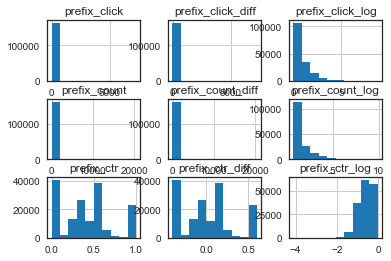

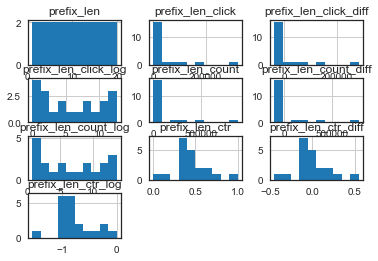

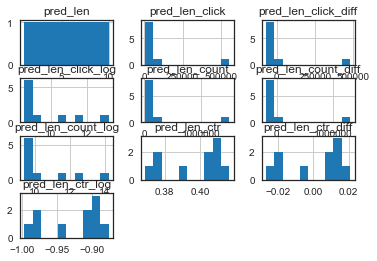

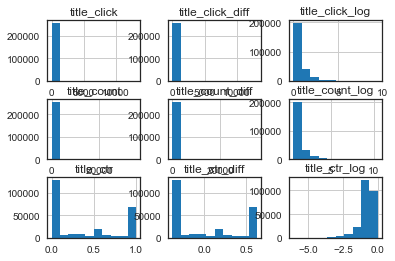

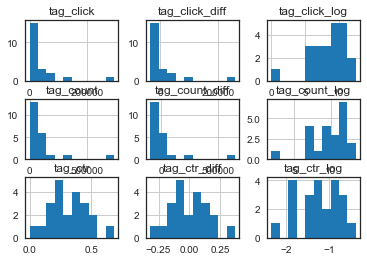

In [10]:
# 计算prefix、title、tag的数量，点击数，点击率及其loglp值
items = ['prefix', 'prefix_len', 'pred_len', 'title', 'tag']
for item in items:
    temp = train_data.groupby(item, as_index = False)['label'].agg({item+'_click':'sum', item+'_count':'count'})
    temp[item+'_click_diff'] = temp[item+'_click'] - temp[item+'_click'].mean()
    temp[item+'_count_diff'] = temp[item+'_count'] - temp[item+'_count'].mean()
    temp[item+'_click_log'] = np.log1p(temp[item+'_click'])
    temp[item+'_count_log'] = np.log1p(temp[item+'_count'])
    temp[item+'_ctr'] = temp[item+'_click']/(temp[item+'_count'])
    temp[item+'_ctr_diff'] = temp[item+'_ctr'] - temp[item+'_ctr'].mean()
    temp[item+'_ctr_log'] = np.log1p(temp[item+'_click']) - np.log1p(temp[item+'_count'])
    # temp[item+'_ctr_log'] = temp[item+'_click_log'] - temp[item+'_count_log']
    temp.hist()
    train_data = pd.merge(train_data, temp, on=item, how='left')
    test_data = pd.merge(test_data, temp, on=item, how='left')

ValueError: cannot insert pred_len, already exists

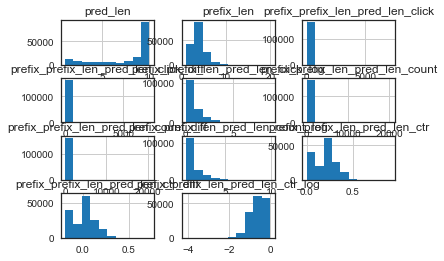

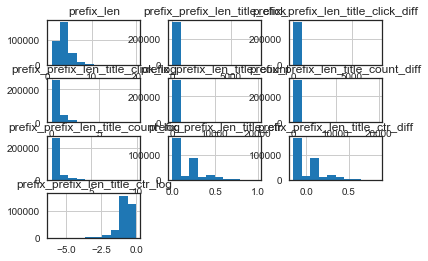

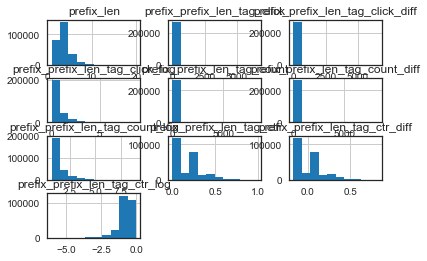

In [14]:
# prefix&title,prefix&tag, title&tag
for i in range(len(items)):
    for j in range(i+1, len(items)):
        for k in range(i+2, len(items)):
            item_g = [items[i], items[j], items[k]]
            temp = train_data.groupby(item_g, as_index=False)['label'].agg({'_'.join(item_g)+'_click': 'sum','_'.join(item_g)+'_count':'count'})

            temp['_'.join(item_g)+'_click_diff'] = temp['_'.join(item_g)+'_click'] - temp['_'.join(item_g)+'_click'].mean()
            temp['_'.join(item_g)+'_count_diff'] = temp['_'.join(item_g)+'_count'] - temp['_'.join(item_g)+'_count'].mean()

            temp['_'.join(item_g)+'_click_log'] = np.log1p(temp['_'.join(item_g)+'_click'])
            temp['_'.join(item_g)+'_count_log'] = np.log1p(temp['_'.join(item_g)+'_count'])

            temp['_'.join(item_g)+'_ctr'] = temp['_'.join(item_g)+'_click']/(temp['_'.join(item_g)+'_count']+3)
            temp['_'.join(item_g)+'_ctr_diff'] = temp['_'.join(item_g)+'_ctr'] - temp['_'.join(item_g)+'_ctr'].mean()
            temp['_'.join(item_g)+'_ctr_log'] = np.log1p(temp['_'.join(item_g)+'_click']) - np.log1p(temp['_'.join(item_g)+'_count'])
            # temp[item+'_ctr_log'] = temp[item+'_click_log'] - temp[item+'_count_log']
            temp.hist()
            train_data = pd.merge(train_data, temp, on=item_g, how='left')
            test_data = pd.merge(test_data, temp, on=item_g, how='left')

In [ ]:
train_df.columns[train_df.dtypes=='object']

In [199]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Columns: 103 entries, prefix to tag_ctr_log_rela
dtypes: float64(82), int64(16), object(5)
memory usage: 1.5+ GB


In [202]:
obj_cols = train_df.columns[train_df.dtypes=='object']
obj_cols

Index(['prefix', 'query_prediction', 'title', 'tag', 'pred_list'], dtype='object')

In [ ]:
train_df = train_df.drop(['pred_list'],axis=1)
valid_df = valid_df.drop(['pred_list'],axis=1)
test_data = test_data.drop(['pred_list'],axis=1)

In [203]:
int_cols = train_df.columns[train_df.dtypes=='int64']
int_cols

Index(['label', 'prefix_click', 'prefix_count', 'prefix_len',
       'prefixlen_click', 'prefixlen_count', 'pred_len', 'predlen_click',
       'predlen_count', 'title_click', 'title_count', 'title_len',
       'titlelen_click', 'titlelen_count', 'tag_click', 'tag_count'],
      dtype='object')

In [212]:
# 对数据按照格式进行压缩重新存储
def compressData(inputData):
    '''
    :parameters: inputData: pd.Dataframe
    :return: inputData: pd.Dataframe
    :Purpose: 
    压缩csv中的数据，通过改变扫描每列的dtype，转换成适合的大小
    例如: int64, 检查最小值是否存在负数，是则声明signed，否则声明unsigned，并转换更小的int size
    对于object类型，则会转换成category类型，占用内存率小
    参考来自：https://www.jiqizhixin.com/articles/2018-03-07-3
    '''
    for eachType in set(inputData.dtypes.values):
        ##检查属于什么类型
        if 'int' in str(eachType):
            ## 对每列进行转换
            for i in inputData.select_dtypes(eachType).columns.values:
                if inputData[i].min() < 0:
                    inputData[i] = pd.to_numeric(inputData[i],downcast='signed')
                else:
                    inputData[i] = pd.to_numeric(inputData[i],downcast='unsigned')      
        elif 'float' in str(eachType):
            for i in inputData.select_dtypes(eachType).columns.values:   
                inputData[i] = pd.to_numeric(inputData[i],downcast='float')
        elif 'object' in str(eachType):
            for i in inputData.select_dtypes(eachType).columns.values: 
                inputData[i] = inputData[i].astype('category')
    return inputData

In [213]:
# userInfo = pd.read_csv('d:/JulyCompetition/input/user_log_format1.csv')
# print('Before compressed:\n',userInfo.info())
train_df = compressData(train_df)
print('After compressed:\n',train_df.info())
valid_df = compressData(valid_df)
print('After compressed:\n',valid_df.info())
test_data = compressData(test_data)
print('After compressed:\n',test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Columns: 102 entries, prefix to tag_ctr_log_rela
dtypes: category(4), float32(82), uint16(4), uint32(8), uint8(4)
memory usage: 773.9 MB
After compressed:
 None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 102 entries, prefix to tag_ctr_log_rela
dtypes: category(4), float32(86), uint32(8), uint8(4)
memory usage: 21.9 MB
After compressed:
 None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 102 entries, prefix to tag_ctr_log_rela
dtypes: category(4), float32(86), int8(1), uint32(8), uint8(3)
memory usage: 21.9 MB
After compressed:
 None


In [217]:
# 对于valid和test数据集中新出现的数值型特征，所有的缺失值用均值代替
for col in valid_df.columns[train_df.dtypes != 'category']:
    valid_df.fillna(valid_df[col].mean())
for col in test_data.columns[test_data.dtypes != 'category']:
    test_data.fillna(test_data[col].mean())

ValueError: fill value must be in categories

In [ ]:
# 对数值型特征手动标准化
numeric_cols = totalActions.columns[totalActions.dtypes == 'float64']
numeric_cols
numeric_col_means = totalActions.loc[:, numeric_cols].mean()
numeric_col_std = totalActions.loc[:, numeric_cols].std()
totalActions.loc[:, numeric_cols] = (totalActions.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

In [221]:
# dump feature
train_df.to_csv('d:/oppo/input/train_data_feature20181013.csv',sep='\t',index=False)
valid_df.to_csv('d:/oppo/input/valid_data_feature20181013.csv',sep='\t',index=False)
test_data.to_csv('d:/oppo/input/test_data_feature20181013.csv',sep='\t',index=False)
# pickle.dump(train_data,open('d:/oppo/input/train_data_feature','wb'))
# pickle.dump(test_data,open('d:/oppo/input/test_data_feature','wb'))

In [250]:
# load feature
# train_data = pickle.load(open('d:/oppo/input/train_data_feature','rb'))
# test_data = pickle.load(open('d:/oppo/input/test_data_feature','rb'))
train_df = pd.read_csv('d:/oppo/input/train_data_feature20181013.csv', sep='\t')
valid_df = pe.read_csv('d:/oppo/input/valid_data_feature20181013.csv',sep='\t')
test_data = pd.read_csv('d:/oppo/input/test_data_feature20181013.csv', sep='\t')

NameError: name 'pe' is not defined

In [249]:
train_df.head(1)

   Unnamed: 0 prefix                                   query_prediction title  \
0           0     小品  {"小品大全宋小宝": "0.009", "小品相亲": "0.012", "小品剧本": ...    小品   

  tag  label  prefix_click  prefix_count  prefix_click_log  prefix_count_log  \
0  阅读      0            58           150          4.077538           5.01728   

   prefix_click_log2  prefix_count_log2  prefix_click_diff  prefix_count_diff  \
0           1.624826           1.794635           53.26241          137.26788   

   prefix_click_ratio  prefix_count_ratio  prefix_click_ratio_log  \
0            0.000078            0.000075               -9.442522   

   prefix_count_ratio_log  prefix_ctr_abs  prefix_ctr_smooth  prefix_ctr_diff  \
0               -9.491379        0.386667           0.385527        -0.013361   

   prefix_ctr_rela  prefix_ctr_log_abs  prefix_ctr_log_smooth  \
0          -0.0334            0.812699               0.762677   

   prefix_ctr_log_diff  prefix_ctr_log_rela  prefix_len  prefixlen_click  \
0   

In [ ]:
train_df_ = train_df.drop(['prefix','query_prediction', 'title', 'tag'], axis = 1)
valid_df_ = valid_df.drop(['prefix','query_prediction', 'title', 'tag'], axis = 1)
test_data_ = test_data.drop(['prefix','query_prediction', 'title', 'tag'], axis = 1)

In [241]:
print('train beginning')

X = train_df_.drop(['label'], axis = 1)
y = train_df_['label']
X_valid = valid_df_.drop(['label'], axis = 1)
y_valid = valid_df_['label']
X_test = test_data_.drop(['label'], axis = 1)

print('================================')
print(X.shape)
print(y.shape)
print('================================')


# xx_logloss = []
# xx_submit = []
# N = 5
# skf = StratifiedKFold(n_splits=N, random_state=2018, shuffle=True)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 32,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

lgb_train = lgb.Dataset(X, y)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5000,
                valid_sets=lgb_eval,
                early_stopping_rounds=50,
                verbose_eval=50,
                )


train beginning
(2000000, 97)
(2000000,)
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.570184
[100]	valid_0's binary_logloss: 0.524021
[150]	valid_0's binary_logloss: 0.510289
[200]	valid_0's binary_logloss: 0.514978
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.510018


In [242]:
# f1-score on train data
print('f1-score on validation data:',f1_score(y, np.where(gbm.predict(X, num_iteration=gbm.best_iteration)>0.5, 1,0)))

f1-score on validation data: 0.7382430451422305


f1-score on validation data: 0.6374839851137819
defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.5100182041374886}})


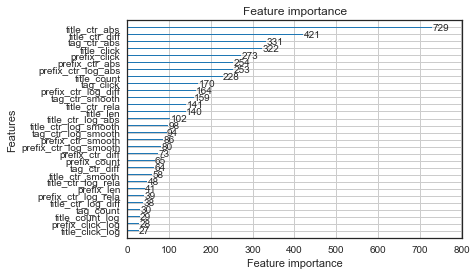

In [243]:
# f1-score on validation data
print('f1-score on validation data:',f1_score(y_valid, np.where(gbm.predict(X_valid, num_iteration=gbm.best_iteration)>0.5, 1,0)))
print(gbm.best_score)


<Figure size 864x432 with 0 Axes>

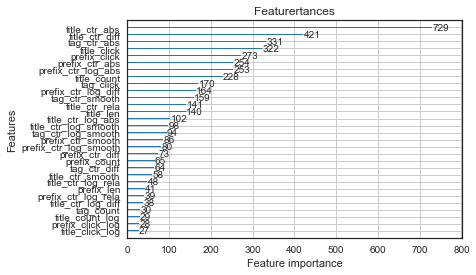

In [245]:
plt.figure(figsize=(12,6))
lgb.plot_importance(gbm, max_num_features=30)
plt.title("Featurertances")
plt.show()

In [233]:
# predict test data
test_data['label'] = gbm.predict(X_test, num_iteration=gbm.best_iteration)
test_data['label'] = test_data['label'].apply(lambda x: round(x))
test_data['label'].describe()


count    50000.000000
mean         0.285960
std          0.451875
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [235]:
# save commit file
test_data['label'].to_csv('d:/oppo/submit/result201810132220.csv',header=None,index = False)

In [7]:
def merge_data(train_data,valid_data,test_data):
    print('merge train,valid,test data start')
    train_data = train_data[['prefix','title', 'tag']].dropna().drop_duplicates()
    valid_data = valid_data[['prefix','title', 'tag']].dropna().drop_duplicates()
    test_data = test_data[['prefix','title', 'tag']].dropna().drop_duplicates()
    all_data = pd.concat([train_data,valid_data,test_data]).drop_duplicates().reset_index()
    print('all prefix:',all_data.prefix.nunique())
    print('all title:',all_data.title.nunique())
    print('all tag:',all_data.tag.nunique())
    print('merge train,valid,test data end')
    return all_data

In [8]:
all_data = merge_data(train_df,valid_df,test_A_df)

merge train,valid,test data start
all prefix: 166659
all title: 259387
all tag: 22
merge train,valid,test data end


In [13]:
# prefix对应的title数量
title_cnt = all_data.groupby(['prefix'])['title'].nunique()
# prefix对应的tag数量
tag_cnt = all_data.groupby(['prefix'])['tag'].nunique()

typeCount_result = pd.concat([title_cnt,tag_cnt],axis=1)
del title_cnt,tag_cnt
typeCount_result.rename(columns={'title':'title_cnt','tag':'tag_cnt'},inplace=True)
typeCount_result.reset_index(inplace=True)
typeCount_result


,prefix,title_cnt,tag_cnt
0,#,3,2
1,%,4,1
2,&,5,2
3,(女人,1,1
4,*p++,1,1
5,-,1,1
6,.,6,5
7,.,2,2
8,...,1,1
9,...b,2,2


In [15]:
## 将统计好的数量进行拼接
train_df = pd.merge(train_df,typeCount_result,how='left',on=['prefix'])
valid_df = pd.merge(valid_df,typeCount_result,how='left',on=['prefix'])
test_A_df = pd.merge(test_A_df,typeCount_result,how='left',on=['prefix'])
del typeCount_result

In [16]:

def label_encode(all_data,data):
    print('feature engining start')
    le = preprocessing.LabelEncoder()
    for col in ['prefix','title','tag']:
        le.fit(all_data[col])
        data[col] = le.transform(data[col])
    del data['query_prediction']
    
    print('feature engining end')
    return data

In [17]:
train = label_encode(all_data,train_df)
valid = label_encode(all_data,valid_df)
test = label_encode(all_data,test_A_df)

feature engining start
feature engining end
feature engining start
feature engining end
feature engining start
feature engining end


In [80]:
for col in ['prefix','title','tag']:
    data_train[col] = data_train[col].astype(str)
    data_valid[col] = data_valid[col].astype(str)
    data_test[col] = data_test[col].astype(int)

In [20]:
# 构造训练集
x_train = train.loc[:,train.columns != 'label']
y_train = train.loc[:,train.columns == 'label']
y_train = np.array(y_train).reshape((-1,))
x_valid = valid.loc[:,valid.columns != 'label']
y_valid = valid.loc[:,valid.columns == 'label']
y_valid = np.array(y_valid).reshape((-1,))

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_valid, label=y_valid)

### 直接使用label编码，xgboost训练

In [46]:
# 对prefix，title，tag进行label编码，直接进行训练

#K折的切分器
# kf = KFold(n_splits=2, shuffle=True, random_state=1234)

xgboost_model = xgb.XGBClassifier().fit(x_train, y_train)
#预测结果
pred = xgboost_model.predict(x_valid)
#标准答案
ground_truth = y_valid
print(confusion_matrix(ground_truth, pred))

[[29514  1901]
 [16204  2381]]


In [78]:
test_A_df.head()

   prefix   title tag
0  136894  214247   2
1   13766   23224  15
2     808    1717  21
3  161127  206239  18
4   40270   64298  12

In [47]:
f1_score(ground_truth, pred)

0.20824769318231515

In [48]:
precision_score(ground_truth, pred)

0.5560485754320411

In [49]:
recall_score(ground_truth, pred)

0.12811407048695184

In [81]:
submit = xgboost_model.predict(data_test)
submit

array([0, 0, 0, ..., 0, 1, 0])

In [86]:
submit = submit.reshape(-1,1)
submit = pd.DataFrame(submit)
submit.to_csv('d:/oppo/submit/submit201811011052.csv',header=None,index=None)

### 对prefix，title，tag进行label编码，加入prefix的title数量，tag数量特征### 

In [22]:
# # 对prefix，title，tag进行label编码，加入prefix的title数量，tag数量特征

#K折的切分器
# kf = KFold(n_splits=2, shuffle=True, random_state=1234)

xgboost_model = xgb.XGBClassifier().fit(x_train, y_train)
#预测结果
pred = xgboost_model.predict(x_valid)
#标准答案
ground_truth = y_valid
print(confusion_matrix(ground_truth, pred))

[[29945  1470]
 [16465  2120]]


In [23]:
print(f1_score(ground_truth,pred))
print(precision_score(ground_truth,pred))
print(recall_score(ground_truth,pred))

0.19120631341600902
0.5905292479108635
0.11407048695184288


### 统计方法

In [ ]:
# 计算每个prefix的点击率
all_data = merge_data(train_df,valid_df)
prefix_info  = all_data[['prefix','label']]
prefix_click_sum = all_data.groupby(['prefix'])['label'].sum()
prefix_click_ratio = all_data.groupby(['prefix'])['label'].mean()

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

train_data = pd.read_table('./data/oppo_round1_train_20180929.txt', 
        names= ['prefix','query_prediction','title','tag','label'], header= None, encoding='utf-8').astype(str)
val_data = pd.read_table('./data/oppo_round1_vali_20180929.txt', 
        names = ['prefix','query_prediction','title','tag','label'], header = None, encoding='utf-8').astype(str)
test_data = pd.read_table('./data/oppo_round1_test_A_20180929.txt',
        names = ['prefix','query_prediction','title','tag'],header = None, encoding='utf-8').astype(str)
train_data = train_data[train_data['label'] != '音乐' ]
test_data['label'] = -1

train_data = pd.concat([train_data,val_data])
train_data['label'] = train_data['label'].apply(lambda x: int(x))
test_data['label'] = test_data['label'].apply(lambda x: int(x))
items = ['prefix', 'title', 'tag']

for item in items:
    temp = train_data.groupby(item, as_index = False)['label'].agg({item+'_click':'sum', item+'_count':'count'})
    temp[item+'_ctr'] = temp[item+'_click']/(temp[item+'_count'])
    train_data = pd.merge(train_data, temp, on=item, how='left')
    test_data = pd.merge(test_data, temp, on=item, how='left')
for i in range(len(items)):
    for j in range(i+1, len(items)):
        item_g = [items[i], items[j]]
        temp = train_data.groupby(item_g, as_index=False)['label'].agg({'_'.join(item_g)+'_click': 'sum','_'.join(item_g)+'count':'count'})
        temp['_'.join(item_g)+'_ctr'] = temp['_'.join(item_g)+'_click']/(temp['_'.join(item_g)+'count']+3)
        train_data = pd.merge(train_data, temp, on=item_g, how='left')
        test_data = pd.merge(test_data, temp, on=item_g, how='left')
train_data_ = train_data.drop(['prefix', 'query_prediction', 'title', 'tag'], axis = 1)
test_data_ = test_data.drop(['prefix', 'query_prediction', 'title', 'tag'], axis = 1)

print('train beginning')

X = np.array(train_data_.drop(['label'], axis = 1))
y = np.array(train_data_['label'])
X_test_ = np.array(test_data_.drop(['label'], axis = 1))
print('================================')
print(X.shape)
print(y.shape)
print('================================')


xx_logloss = []
xx_submit = []
N = 5
skf = StratifiedKFold(n_splits=N, random_state=42, shuffle=True)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 32,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

for k, (train_in, test_in) in enumerate(skf.split(X, y)):
    print('train _K_ flod', k)
    X_train, X_test, y_train, y_test = X[train_in], X[test_in], y[train_in], y[test_in]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=5000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=50,
                    verbose_eval=50,
                    )
    print(f1_score(y_test, np.where(gbm.predict(X_test, num_iteration=gbm.best_iteration)>0.5, 1,0)))
    xx_logloss.append(gbm.best_score['valid_0']['binary_logloss'])
    xx_submit.append(gbm.predict(X_test_, num_iteration=gbm.best_iteration))

print('train_logloss:', np.mean(xx_logloss))
s = 0
for i in xx_submit:
    s = s + i

test_data_['label'] = list(s / N)
test_data_['label'] = test_data_['label'].apply(lambda x: round(x))
print('test_logloss:', np.mean(test_data_.label))
test_data_['label'].to_csv('./submit/result.csv',index = False)